### Imports

In [1]:
import networkx as nx
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from IPython.display import display

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer 
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import F1Score

from dgl.nn.pytorch import GraphConv, SAGEConv
from ray import tune

import warnings
warnings.filterwarnings('ignore')

#### Creating dataset as required

In [2]:
#df=pd.read_csv('Data/IntellectualDisability/STRING network - 1 default node_au.csv')
# df_sel=pd.DataFrame()
# df_sel[['Id','Gene','canonical']]=df[['name','query term','stringdb::canonical name']]
# df_sel.to_csv('Data/IntellectualDisability/Autism_Id_Info.csv',index=False)

In [3]:
#df=pd.read_csv('Data/IntellectualDisability/STRING network - 1 default edge_au.csv') name contains connection from gene1 to gene2 in the format
#  '10090.ENSMUSP00000000001 (pp) 10090.ENSMUSP00000022380'     <-    df.loc[1,'shared name']

# df_sel=pd.DataFrame()
# df_sel[['gene1','gene2']]=df['name'].str.split('\s+\([^()]+\)\s+', expand=True)
# df_sel['score']=df['stringdb::score']
# df_sel.to_csv('Data/IntellectualDisability/Autism_gene_links.csv',index=False)

In [4]:
# df_id=pd.read_csv('Data/IntellectualDisability/Autism_Id_Info.csv')
# df_link=pd.read_csv('Data/IntellectualDisability/Autism_gene_links.csv')
# df_link['gene1'] = df_link['gene1'].map(df_id.set_index('Id')['Gene'])
# df_link['gene2'] = df_link['gene2'].map(df_id.set_index('Id')['Gene'])
# df_link.to_csv('Data/IntellectualDisability/Autism_gene_links_GeneName.csv',index=False)

#### Data Processing

In [5]:
df_link_original=pd.read_csv('Data/IntellectualDisability/Autism_gene_links_GeneName.csv')
#selecting links with confidence score > 0.8
df_link=df_link_original[df_link_original['score']>0.8]
df_link

,gene1,gene2,score
8,gnai3,mapk14,0.874
9,gnai3,gnb5,0.944
10,gnai3,rgs14,0.974
13,gnai3,rgs6,0.867
14,gnai3,ric8b,0.842
...,...,...,...
64459,ddx39b,prpf19,0.841
64462,hnrnpl,prpf19,0.822
64464,lig1,msh3,0.843
64468,rpl31,larp4b,0.805


In [6]:
df_link_original

,gene1,gene2,score
0,gnai3,prkca,0.712
1,gnai3,psmc6,0.488
2,gnai3,rhoc,0.638
3,gnai3,rras2,0.590
4,gnai3,gng5,0.787
...,...,...,...
64467,prpf19,purb,0.421
64468,rpl31,larp4b,0.805
64469,noc2l,nop58,0.933
64470,golga5,ktn1,0.444


In [7]:
# OMICS Data
omics_original=pd.read_csv('Data/IntellectualDisability/Mouse_transcriptome_translatome_proeteome_count_combaseq_au.csv',sep=',')
omics_original['Gene.name']=omics_original['Gene.name'].str.lower()
omics_original
#omics_original['Gene.name'].str.contains(r'[A-Z]').any()

,Gene.name,TL_KO_rep1_32234480,TL_KO_rep2_32234480,TL_KO_rep3_32234480,TL_WT_rep1_32234480,TL_WT_rep2_32234480,TL_WT_rep3_32234480,TL_WT_rep4_32234480,TP_WT_rep1_33199649,TP_WT_rep2_33199649,...,P_WT_rep1_33931071,P_WT_rep2_33931071,P_WT_rep3_33931071,P_WT_rep4_33931071,P_KO_rep1_33931071,P_KO_rep2_33931071,P_KO_rep3_33931071,P_KO_rep4_33931071,P_WT_rep5_33931071,P_WT_rep6_33931071
0,aaas,261.0,267.0,185.0,156.0,141.0,332.0,221.0,152,77,...,0.327956,0.345609,0.308827,0.338002,0.321884,0.321231,0.315788,0.315187,0.328357,0.377411
1,aacs,1500.0,1240.0,880.0,782.0,616.0,1400.0,1018.0,500,270,...,4.000000,3.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,3.000000,5.000000
2,aagab,584.0,339.0,676.0,863.0,657.0,565.0,399.0,208,131,...,0.108902,0.123755,0.097470,0.118669,0.117453,0.117160,0.115340,0.127513,0.118587,0.116705
3,aak1,6739.0,5076.0,4471.0,3493.0,2518.0,3924.0,1413.0,3017,1483,...,13.000000,16.000000,9.000000,13.000000,13.000000,16.000000,16.000000,13.000000,13.000000,13.000000
4,aamdc,94.0,87.0,104.0,381.0,238.0,273.0,320.0,78,29,...,0.221607,0.209806,0.342850,0.256408,0.227316,0.212643,0.206901,0.213825,0.236323,0.229871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3981,zw10,283.0,183.0,130.0,205.0,178.0,321.0,214.0,112,47,...,0.357760,0.351253,0.410755,0.376953,0.358183,0.356021,0.345280,0.365854,0.366276,0.370524
3982,zwint,5242.0,5037.0,4122.0,4574.0,4027.0,6003.0,5724.0,2514,1372,...,19.000000,18.000000,20.000000,19.000000,18.000000,19.000000,19.000000,19.000000,19.000000,19.000000
3983,zyg11b,2997.0,2484.0,2414.0,2684.0,2580.0,3639.0,3240.0,1612,839,...,11.000000,11.000000,0.904460,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
3984,zyx,626.0,355.0,380.0,257.0,324.0,486.0,376.0,228,151,...,0.970315,0.737611,2.000000,0.788688,0.951107,0.764446,0.804698,0.723949,0.879524,0.728029


In [8]:
len([col for col in omics_original.columns if col.startswith('TL')])

31

In [9]:
len([col for col in omics_original.columns if col.startswith('TP')])

10

In [10]:
len([col for col in omics_original.columns if col.startswith('P')])

10

In [11]:
# Creating gene dataset as per requirement

# genes_p=pd.read_excel('Data/dataset_frmp_au.xlsx',sheet_name='positives')  #df.keys to read sheet name with sheet_name=None
# genes_p.columns=['Gene','Pathogenic']
# genes_p['Pathogenic'].loc[genes_p['Pathogenic']==0]=2

# genes_n=pd.read_excel('Data/dataset_frmp_au.xlsx',sheet_name='negatives')
# genes_n.columns=['Gene']
# genes_n['Pathogenic']=0

# genes=pd.concat([genes_p,genes_n],axis=0,ignore_index=True)
# genes = genes.sample(frac=1).reset_index(drop=True)

# genes.to_csv('Data/Autism_genes.csv',index=False)

In [12]:
genes_original=pd.read_csv('Data/IntellectualDisability/Autism_genes.csv')
genes_original['Pathogenic'].value_counts()

0    2610
2     421
1      32
Name: Pathogenic, dtype: int64

In [13]:
genes_original[genes_original['Gene']=='fmr1']

,Gene,Pathogenic
1827,fmr1,2


In [14]:
genes_original['Gene'].str.contains(r'[A-Z]').any()

False

In [15]:
len(genes_original)

3063

In [16]:
# creating network graph
G = nx.Graph()
G.add_nodes_from([]) # number of nodes added = number of unique genes in links df that is added below.
G.add_edges_from(np.asarray(df_link[['gene1','gene2']]))

nodes_ss=list(G.nodes)

genes=genes_original[genes_original['Gene'].isin(nodes_ss)]

In [17]:
genes['Pathogenic'].value_counts()

0    2047
2     309
1      26
Name: Pathogenic, dtype: int64

In [18]:
len(nodes_ss)

2382

In [19]:
len(genes)

2382

In [20]:
len(list(G.edges))

15237

### Multi-omics

In [21]:
all_data = pd.merge(genes, omics_original, left_on="Gene", right_on="Gene.name", how="inner").drop('Gene.name',axis=1)
all_data

,Gene,Pathogenic,TL_KO_rep1_32234480,TL_KO_rep2_32234480,TL_KO_rep3_32234480,TL_WT_rep1_32234480,TL_WT_rep2_32234480,TL_WT_rep3_32234480,TL_WT_rep4_32234480,TP_WT_rep1_33199649,...,P_WT_rep1_33931071,P_WT_rep2_33931071,P_WT_rep3_33931071,P_WT_rep4_33931071,P_KO_rep1_33931071,P_KO_rep2_33931071,P_KO_rep3_33931071,P_KO_rep4_33931071,P_WT_rep5_33931071,P_WT_rep6_33931071
0,ganab,2,2487.0,2385.0,2287.0,2841.0,2802.0,3742.0,3075.0,1283,...,12.000000,11.000000,12.000000,11.000000,11.000000,12.000000,12.000000,11.000000,12.000000,12.000000
1,fus,2,7602.0,3207.0,6575.0,335.0,358.0,961.0,251.0,3941,...,5.000000,4.000000,1.000000,15.000000,4.000000,5.000000,5.000000,10.000000,5.000000,13.000000
2,kpna3,0,2154.0,1747.0,1743.0,1659.0,1297.0,2147.0,1661.0,901,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,8.000000,6.000000,6.000000
3,napg,0,3528.0,3357.0,3093.0,2616.0,2294.0,3401.0,3048.0,1676,...,11.000000,14.000000,8.000000,13.000000,11.000000,14.000000,13.000000,14.000000,11.000000,13.000000
4,trappc11,0,1802.0,1220.0,1226.0,1329.0,1094.0,1907.0,1590.0,744,...,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,tecr,0,4409.0,4670.0,3822.0,4569.0,4652.0,6908.0,5430.0,2317,...,18.000000,18.000000,18.000000,20.000000,18.000000,18.000000,18.000000,20.000000,18.000000,20.000000
2378,pomk,0,338.0,214.0,222.0,304.0,343.0,567.0,313.0,139,...,0.063357,0.066374,0.094573,0.072533,0.066030,0.065775,0.061952,0.069200,0.066570,0.075426
2379,adipor1,0,659.0,726.0,672.0,506.0,517.0,685.0,503.0,263,...,0.076498,0.107408,0.072244,0.088622,0.077609,0.084086,0.082940,0.083664,0.077323,0.081134
2380,tubgcp3,0,578.0,511.0,418.0,414.0,480.0,825.0,609.0,318,...,0.502107,0.571103,0.522752,0.499977,0.512907,0.500529,0.502679,0.503527,0.505105,0.502996


In [22]:
#candidate genes
candidate_genes=pd.read_csv('Data/IntellectualDisability/autisms_candidates.csv')['Gene'].values.tolist()
print(len([node for node in candidate_genes if node in all_data['Gene'].values]))
[node for node in candidate_genes if node not in all_data['Gene'].values]

27


['nr2f1', 'stim2', 'trim3', 'wiz', 'ehmt']

In [23]:
# candidate genes whose labels are known
all_data[(all_data['Gene'].isin(candidate_genes))&(all_data['Pathogenic']==1)].shape

(8, 53)

In [24]:
all_data_tr_weights=all_data.drop('Pathogenic',axis=1)
all_data_tr_weights

,Gene,TL_KO_rep1_32234480,TL_KO_rep2_32234480,TL_KO_rep3_32234480,TL_WT_rep1_32234480,TL_WT_rep2_32234480,TL_WT_rep3_32234480,TL_WT_rep4_32234480,TP_WT_rep1_33199649,TP_WT_rep2_33199649,...,P_WT_rep1_33931071,P_WT_rep2_33931071,P_WT_rep3_33931071,P_WT_rep4_33931071,P_KO_rep1_33931071,P_KO_rep2_33931071,P_KO_rep3_33931071,P_KO_rep4_33931071,P_WT_rep5_33931071,P_WT_rep6_33931071
0,ganab,2487.0,2385.0,2287.0,2841.0,2802.0,3742.0,3075.0,1283,839,...,12.000000,11.000000,12.000000,11.000000,11.000000,12.000000,12.000000,11.000000,12.000000,12.000000
1,fus,7602.0,3207.0,6575.0,335.0,358.0,961.0,251.0,3941,534,...,5.000000,4.000000,1.000000,15.000000,4.000000,5.000000,5.000000,10.000000,5.000000,13.000000
2,kpna3,2154.0,1747.0,1743.0,1659.0,1297.0,2147.0,1661.0,901,554,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,8.000000,6.000000,6.000000
3,napg,3528.0,3357.0,3093.0,2616.0,2294.0,3401.0,3048.0,1676,727,...,11.000000,14.000000,8.000000,13.000000,11.000000,14.000000,13.000000,14.000000,11.000000,13.000000
4,trappc11,1802.0,1220.0,1226.0,1329.0,1094.0,1907.0,1590.0,744,370,...,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,tecr,4409.0,4670.0,3822.0,4569.0,4652.0,6908.0,5430.0,2317,1563,...,18.000000,18.000000,18.000000,20.000000,18.000000,18.000000,18.000000,20.000000,18.000000,20.000000
2378,pomk,338.0,214.0,222.0,304.0,343.0,567.0,313.0,139,131,...,0.063357,0.066374,0.094573,0.072533,0.066030,0.065775,0.061952,0.069200,0.066570,0.075426
2379,adipor1,659.0,726.0,672.0,506.0,517.0,685.0,503.0,263,196,...,0.076498,0.107408,0.072244,0.088622,0.077609,0.084086,0.082940,0.083664,0.077323,0.081134
2380,tubgcp3,578.0,511.0,418.0,414.0,480.0,825.0,609.0,318,133,...,0.502107,0.571103,0.522752,0.499977,0.512907,0.500529,0.502679,0.503527,0.505105,0.502996


In [25]:
scaler = MinMaxScaler()
transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')

all_data.iloc[:, 2:] = scaler.fit_transform(transformer.fit_transform(all_data.iloc[:, 2:]))

### Graphs with different edge weights

In [26]:
G_none = nx.subgraph(G, all_data["Gene"])
G_cca = nx.subgraph(G, all_data["Gene"])
G_pls = nx.subgraph(G, all_data["Gene"])
G_pearson = nx.subgraph(G, all_data["Gene"])

G_gini=nx.subgraph(G,all_data["Gene"])

G_shannon=nx.subgraph(G,all_data["Gene"])
G_renyi=nx.subgraph(G,all_data["Gene"])
G_tsallis=nx.subgraph(G,all_data["Gene"])
G_mutualInfo=nx.subgraph(G,all_data["Gene"])
G_kl=nx.subgraph(G,all_data["Gene"])
G_js=nx.subgraph(G,all_data["Gene"])

In [27]:
relabel_nodes = dict((v,k) for k,v in all_data.iloc[:,0].to_dict().items())

In [28]:
G_none = nx.relabel_nodes(G_none, relabel_nodes, copy=True)
G_cca = nx.relabel_nodes(G_cca, relabel_nodes, copy=True)
G_pls = nx.relabel_nodes(G_pls, relabel_nodes, copy=True)
G_pearson = nx.relabel_nodes(G_pearson, relabel_nodes, copy=True)

G_gini=nx.relabel_nodes(G_gini,relabel_nodes,copy=True)

G_shannon=nx.relabel_nodes(G_shannon,relabel_nodes,copy=True)
G_renyi=nx.relabel_nodes(G_renyi,relabel_nodes,copy=True)
G_tsallis=nx.relabel_nodes(G_tsallis,relabel_nodes,copy=True)
G_mutualInfo=nx.relabel_nodes(G_mutualInfo,relabel_nodes,copy=True)
G_kl=nx.relabel_nodes(G_kl,relabel_nodes,copy=True)
G_js=nx.relabel_nodes(G_js,relabel_nodes,copy=True)

In [29]:
len(G_cca.nodes)

2382

### Adding edge weights

#### CCA

In [30]:
all_data_transposed = all_data_tr_weights.T
all_data_transposed.columns = all_data_transposed.iloc[0] #set row 0 as column names
all_data_transposed = all_data_transposed.drop(["Gene"], axis=0) # remove row with pathogenic label
all_data_transposed

Gene,ganab,fus,kpna3,napg,trappc11,rpl32,szt2,sf3b3,ythdf2,snrpe,...,sec23b,ppp6r3,ndufaf3,acss2,cgn,tecr,pomk,adipor1,tubgcp3,lig1
TL_KO_rep1_32234480,2487.0,7602.0,2154.0,3528.0,1802.0,1431.0,214.0,3755.0,1103.0,218.0,...,1079.0,1910.0,492.0,1066.0,15.0,4409.0,338.0,659.0,578.0,190.0
TL_KO_rep2_32234480,2385.0,3207.0,1747.0,3357.0,1220.0,2385.0,211.0,2488.0,803.0,274.0,...,850.0,1187.0,495.0,1119.0,66.0,4670.0,214.0,726.0,511.0,86.0
TL_KO_rep3_32234480,2287.0,6575.0,1743.0,3093.0,1226.0,2385.0,178.0,2481.0,786.0,314.0,...,802.0,1114.0,387.0,616.0,54.0,3822.0,222.0,672.0,418.0,70.0
TL_WT_rep1_32234480,2841.0,335.0,1659.0,2616.0,1329.0,1771.0,225.0,2400.0,730.0,486.0,...,698.0,1276.0,381.0,224.0,32.0,4569.0,304.0,506.0,414.0,135.0
TL_WT_rep2_32234480,2802.0,358.0,1297.0,2294.0,1094.0,1645.0,331.0,1714.0,578.0,211.0,...,553.0,931.0,319.0,44.0,18.0,4652.0,343.0,517.0,480.0,72.0
TL_WT_rep3_32234480,3742.0,961.0,2147.0,3401.0,1907.0,1932.0,316.0,3146.0,1136.0,321.0,...,1006.0,1934.0,530.0,427.0,23.0,6908.0,567.0,685.0,825.0,234.0
TL_WT_rep4_32234480,3075.0,251.0,1661.0,3048.0,1590.0,1920.0,383.0,2317.0,845.0,400.0,...,717.0,1267.0,471.0,487.0,38.0,5430.0,313.0,503.0,609.0,76.0
TP_WT_rep1_33199649,1283,3941,901,1676,744,720,178,1174,429,125,...,409,705,196,234,56,2317,139,263,318,51
TP_WT_rep2_33199649,839,534,554,727,370,626,89,691,219,69,...,211,352,139,349,1,1563,131,196,133,34
TP_KO_rep1_33199649,1559,725,970,1781,888,1211,91,1452,546,197,...,429,710,261,64,81,2870,181,340,357,68


In [31]:
def checkIfNull(df):
    cols=[]
    for i in df.columns:
        if df[i].isnull().any():
            cols.append(i)
        else:
            continue
    if not cols:
        print("No missing values")
    else:
        print(cols)
checkIfNull(all_data)

No missing values


In [32]:
X1 = all_data_transposed

# same scaling and transforming steps as previously
scaler = MinMaxScaler()
transformer = QuantileTransformer(n_quantiles=10, output_distribution='normal')

X1_sc = scaler.fit_transform(transformer.fit_transform(X1))

n_comp=1 #choose number of canonical variates pairs 
cca = CCA(scale=False, n_components=n_comp) #define CCA
cca.fit(X1_sc, X1_sc) #fit scaled data
X1_c, X2_c = cca.transform(X1_sc, X1_sc)

In [33]:
coef_df = pd.DataFrame(np.round(cca.coef_, 6), columns = [X1.columns])
coef_df.index = X1.columns
coef_df

Gene,ganab,fus,kpna3,napg,trappc11,rpl32,szt2,sf3b3,ythdf2,snrpe,...,sec23b,ppp6r3,ndufaf3,acss2,cgn,tecr,pomk,adipor1,tubgcp3,lig1
Gene,,,,,,,,,,,,,,,,,,,,,
ganab,0.020510,0.006974,0.021044,0.011162,0.022720,0.011363,0.011034,0.020774,0.021592,0.014165,...,0.019358,0.021110,0.011339,0.007639,0.004349,0.017914,0.009777,0.009576,0.011763,0.012954
fus,-0.003142,-0.001068,-0.003224,-0.001710,-0.003481,-0.001741,-0.001690,-0.003183,-0.003308,-0.002170,...,-0.002966,-0.003234,-0.001737,-0.001170,-0.000666,-0.002744,-0.001498,-0.001467,-0.001802,-0.001985
kpna3,-0.004038,-0.001373,-0.004143,-0.002198,-0.004473,-0.002237,-0.002173,-0.004090,-0.004251,-0.002789,...,-0.003811,-0.004156,-0.002232,-0.001504,-0.000856,-0.003527,-0.001925,-0.001885,-0.002316,-0.002551
napg,0.000005,0.000002,0.000005,0.000003,0.000006,0.000003,0.000003,0.000005,0.000005,0.000004,...,0.000005,0.000005,0.000003,0.000002,0.000001,0.000004,0.000002,0.000002,0.000003,0.000003
trappc11,0.001285,0.000437,0.001318,0.000699,0.001423,0.000712,0.000691,0.001301,0.001353,0.000887,...,0.001213,0.001323,0.000710,0.000479,0.000272,0.001122,0.000613,0.000600,0.000737,0.000812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tecr,-0.003143,-0.001069,-0.003225,-0.001711,-0.003482,-0.001741,-0.001691,-0.003184,-0.003309,-0.002171,...,-0.002967,-0.003235,-0.001738,-0.001171,-0.000667,-0.002745,-0.001498,-0.001468,-0.001803,-0.001985
pomk,-0.001416,-0.000482,-0.001453,-0.000771,-0.001569,-0.000785,-0.000762,-0.001434,-0.001491,-0.000978,...,-0.001337,-0.001458,-0.000783,-0.000527,-0.000300,-0.001237,-0.000675,-0.000661,-0.000812,-0.000894
adipor1,0.000238,0.000081,0.000244,0.000129,0.000263,0.000132,0.000128,0.000241,0.000250,0.000164,...,0.000224,0.000245,0.000131,0.000089,0.000050,0.000208,0.000113,0.000111,0.000136,0.000150


<AxesSubplot:xlabel='Gene', ylabel='Gene'>

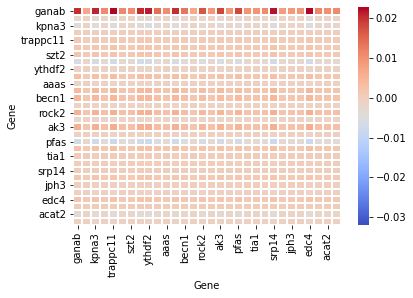

In [34]:
sns.heatmap(coef_df.iloc[0:30, 0:30], cmap='coolwarm', annot=False, linewidths=1, vmin=-0.032)

In [35]:
#transforms a DataFrame from a wide format to a long format by unpivoting the data.
def melt_and_clean(coef_df):
    # get coefficients to use as weights
    coef_df_melted = pd.melt(coef_df, id_vars=None, value_vars=None, var_name='column', value_name='value', 
                             ignore_index = False).reset_index()
    coef_df_melted = coef_df_melted.rename({"Gene":"node1", "column":"node2", "value":"weight"}, axis=1)

    # remove duplicates
    coef_df_melted = coef_df_melted.drop_duplicates(subset=['node1', 'node2'], keep='first')
    return(coef_df_melted)

In [36]:
coef_df_melted_cca = melt_and_clean(coef_df)
coef_df_melted_cca

,node1,node2,weight
0,ganab,ganab,0.020510
1,fus,ganab,-0.003142
2,kpna3,ganab,-0.004038
3,napg,ganab,0.000005
4,trappc11,ganab,0.001285
...,...,...,...
5673919,tecr,lig1,-0.001985
5673920,pomk,lig1,-0.000894
5673921,adipor1,lig1,0.000150
5673922,tubgcp3,lig1,0.002840


In [37]:
cca_graph_genes = pd.merge(df_link, coef_df_melted_cca, left_on=["gene1", "gene2"], right_on=["node1", "node2"], how="inner")
cca_graph_genes = cca_graph_genes.drop(["gene1", "gene2","score"], axis=1)
cca_graph_genes

,node1,node2,weight
0,gnai3,mapk14,-0.003443
1,gnai3,gnb5,-0.003464
2,gnai3,rgs14,-0.002407
3,gnai3,rgs6,-0.003168
4,gnai3,ric8b,-0.002771
...,...,...,...
15232,ddx39b,prpf19,-0.001567
15233,hnrnpl,prpf19,0.001106
15234,lig1,msh3,0.003175
15235,rpl31,larp4b,0.001043


In [38]:
def get_graph_weights(graph_genes, neg_weights,data):
    # keep only the genes that is in the final data
    graph_genes_ = graph_genes[graph_genes['node1'].isin(data['Gene'])]
    graph_genes_ = graph_genes_[graph_genes_["node2"].isin(data['Gene'])]
    if neg_weights == False:
        graph_genes_["weight"] = np.abs(graph_genes_["weight"])
    return(graph_genes_)

In [39]:
def map_node_names_to_numeric(graph_genes_,data):
    # map node names to numerical node numbers for DGL
    graph_genes_['n1'] = graph_genes_['node1'].map(lambda x: data.set_index('Gene').index.get_loc(x))
    graph_genes_['n2'] = graph_genes_['node2'].map(lambda x: data.set_index('Gene').index.get_loc(x))
    return(graph_genes_)

In [40]:
def get_valid_edges(graph_genes, G_, data, neg_weights):
    
    graph_genes_ = get_graph_weights(graph_genes, neg_weights,data)
    graph_genes_ = map_node_names_to_numeric(graph_genes_,data) # takes a while
    #display(graph_genes_)
    
    # create a dict with a tuple of the interacting genes as the key and the weight as value - this is the format needed to add
    # it to the graph
    genes_dict = graph_genes_.iloc[:,2:].set_index(["n1", "n2"]).to_dict(orient='index') #to_dict(orient='index') -> convert the DataFrame to a dictionary with a nested structure
    
    nx.set_edge_attributes(G_, genes_dict, "name")
    # only the edges that exist in the graph now have a weight, so we need to extract these "valid" edges
    
    valid_edges = nx.get_edge_attributes(G_, "name")
    #print(valid_edges)
    # create df of valid edges
    valid_analysis_edges = pd.DataFrame.from_dict(valid_edges).T.reset_index()
    valid_analysis_edges = valid_analysis_edges.rename({'level_0': 'node1', "level_1":"node2"}, axis=1)
    return(valid_analysis_edges)

In [41]:
valid_cca_edges_neg = get_valid_edges(cca_graph_genes, G_cca, all_data, neg_weights=True)
valid_cca_edges_neg

,node1,node2,weight
0,1580,2045,-0.003443
1,1580,1322,-0.003464
2,1580,17,-0.002407
3,1580,2361,-0.003168
4,1580,1564,-0.002771
...,...,...,...
15232,37,603,-0.002405
15233,640,1250,0.001795
15234,2370,1664,0.000515
15235,1057,283,0.001611


In [42]:
valid_cca_edges = get_valid_edges(cca_graph_genes, G_cca, all_data, neg_weights=False)
valid_cca_edges

,node1,node2,weight
0,1580,2045,0.003443
1,1580,1322,0.003464
2,1580,17,0.002407
3,1580,2361,0.003168
4,1580,1564,0.002771
...,...,...,...
15232,37,603,0.002405
15233,640,1250,0.001795
15234,2370,1664,0.000515
15235,1057,283,0.001611


#### Gini Index

In [43]:
gini_list=[]

In [44]:
for (gene1,gene2) in zip(df_link['gene1'],df_link['gene2']):
    expression1 = all_data_transposed[gene1]
    expression2 = all_data_transposed[gene2]
    gini_index = np.abs(expression1 - expression2).sum() / (2 * expression1.sum())
    gini_list.append([gene1, gene2, gini_index])

gini_graph_genes=pd.DataFrame(gini_list,columns=['node1','node2','weight'])
gini_graph_genes

,node1,node2,weight
0,gnai3,mapk14,0.096998
1,gnai3,gnb5,0.206613
2,gnai3,rgs14,0.319582
3,gnai3,rgs6,0.352228
4,gnai3,ric8b,0.336110
...,...,...,...
15232,ddx39b,prpf19,0.063178
15233,hnrnpl,prpf19,0.187905
15234,lig1,msh3,0.657821
15235,rpl31,larp4b,0.241133


In [45]:
valid_gini_edges = get_valid_edges(gini_graph_genes, G_gini, all_data, neg_weights=False)
valid_gini_edges

,node1,node2,weight
0,1580,2045,0.096998
1,1580,1322,0.206613
2,1580,17,0.319582
3,1580,2361,0.352228
4,1580,1564,0.336110
...,...,...,...
15232,37,603,0.451921
15233,640,1250,0.518537
15234,2370,1664,0.290607
15235,1057,283,0.612828


#### PLS

In [46]:
n_comp=1 
PLSR = PLSRegression(scale=False, n_components=n_comp) 
PLSR.fit(X1_sc, X1_sc) 
X1_c, X2_c = PLSR.transform(X1_sc, X1_sc) 

In [47]:
# get analysis results into correlation df
coef_df_pls = pd.DataFrame(np.round(PLSR.coef_, 6), columns = [X1.columns])
coef_df_pls.index = X1.columns
coef_df_pls

Gene,ganab,fus,kpna3,napg,trappc11,rpl32,szt2,sf3b3,ythdf2,snrpe,...,sec23b,ppp6r3,ndufaf3,acss2,cgn,tecr,pomk,adipor1,tubgcp3,lig1
Gene,,,,,,,,,,,,,,,,,,,,,
ganab,0.000481,0.000237,0.000701,0.000371,0.000679,0.000340,0.000363,0.000688,0.000708,0.000400,...,0.000559,0.000702,0.000379,0.000254,0.000138,0.000617,0.000342,0.000343,0.000352,0.000364
fus,0.000237,0.000116,0.000345,0.000182,0.000334,0.000167,0.000179,0.000339,0.000348,0.000197,...,0.000275,0.000345,0.000186,0.000125,0.000068,0.000304,0.000168,0.000169,0.000173,0.000179
kpna3,0.000701,0.000345,0.001023,0.000541,0.000990,0.000496,0.000530,0.001003,0.001033,0.000583,...,0.000815,0.001023,0.000552,0.000370,0.000201,0.000900,0.000498,0.000500,0.000513,0.000531
napg,0.000371,0.000182,0.000541,0.000286,0.000524,0.000262,0.000280,0.000531,0.000546,0.000308,...,0.000431,0.000541,0.000292,0.000196,0.000106,0.000476,0.000263,0.000265,0.000271,0.000281
trappc11,0.000679,0.000334,0.000990,0.000524,0.000958,0.000480,0.000513,0.000971,0.001000,0.000564,...,0.000789,0.000990,0.000535,0.000358,0.000194,0.000871,0.000482,0.000484,0.000497,0.000514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tecr,0.000617,0.000304,0.000900,0.000476,0.000871,0.000437,0.000466,0.000883,0.000909,0.000513,...,0.000717,0.000900,0.000486,0.000326,0.000176,0.000792,0.000438,0.000440,0.000452,0.000467
pomk,0.000342,0.000168,0.000498,0.000263,0.000482,0.000242,0.000258,0.000489,0.000503,0.000284,...,0.000397,0.000498,0.000269,0.000180,0.000098,0.000438,0.000243,0.000244,0.000250,0.000258
adipor1,0.000343,0.000169,0.000500,0.000265,0.000484,0.000243,0.000259,0.000491,0.000505,0.000285,...,0.000399,0.000501,0.000270,0.000181,0.000098,0.000440,0.000244,0.000245,0.000251,0.000260


<AxesSubplot:xlabel='Gene', ylabel='Gene'>

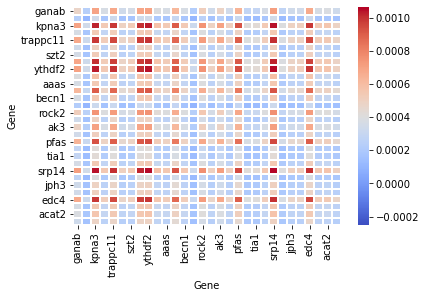

In [48]:
# check the heatmap of the first 30 genes

sns.heatmap(coef_df_pls.iloc[0:30, 0:30], cmap='coolwarm', annot=False, linewidths=1, vmin=-0.00025)

In [49]:
coef_df_melted_pls = melt_and_clean(coef_df_pls)
coef_df_melted_pls

,node1,node2,weight
0,ganab,ganab,0.000481
1,fus,ganab,0.000237
2,kpna3,ganab,0.000701
3,napg,ganab,0.000371
4,trappc11,ganab,0.000679
...,...,...,...
5673919,tecr,lig1,0.000467
5673920,pomk,lig1,0.000258
5673921,adipor1,lig1,0.000260
5673922,tubgcp3,lig1,0.000266


In [50]:
# keep only the genes in the graph
pls_graph_genes = pd.merge(df_link, coef_df_melted_pls, left_on=["gene1", "gene2"], right_on=["node1", "node2"], how="inner")
pls_graph_genes = pls_graph_genes.drop(["gene1", "gene2","score"], axis=1)
pls_graph_genes

,node1,node2,weight
0,gnai3,mapk14,0.000560
1,gnai3,gnb5,0.000646
2,gnai3,rgs14,0.000515
3,gnai3,rgs6,0.000504
4,gnai3,ric8b,0.000543
...,...,...,...
15232,ddx39b,prpf19,0.000378
15233,hnrnpl,prpf19,0.000317
15234,lig1,msh3,0.000281
15235,rpl31,larp4b,0.000575


In [51]:
valid_pls_edges_neg = get_valid_edges(pls_graph_genes, G_pls, all_data, neg_weights=True)
valid_pls_edges_neg

,node1,node2,weight
0,1580,2045,0.000560
1,1580,1322,0.000646
2,1580,17,0.000515
3,1580,2361,0.000504
4,1580,1564,0.000543
...,...,...,...
15232,37,603,0.000205
15233,640,1250,0.000145
15234,2370,1664,0.000520
15235,1057,283,0.000209


In [52]:
valid_pls_edges = get_valid_edges(pls_graph_genes, G_pls, all_data, neg_weights=False)
valid_pls_edges

,node1,node2,weight
0,1580,2045,0.000560
1,1580,1322,0.000646
2,1580,17,0.000515
3,1580,2361,0.000504
4,1580,1564,0.000543
...,...,...,...
15232,37,603,0.000205
15233,640,1250,0.000145
15234,2370,1664,0.000520
15235,1057,283,0.000209


#### Pearson

In [53]:
allT=all_data_transposed.reset_index(drop=True)
s = allT.select_dtypes(include='object').columns
allT[s] = allT[s].astype("float")

corr = allT.corr(method='pearson')
corr

Gene,ganab,fus,kpna3,napg,trappc11,rpl32,szt2,sf3b3,ythdf2,snrpe,...,sec23b,ppp6r3,ndufaf3,acss2,cgn,tecr,pomk,adipor1,tubgcp3,lig1
Gene,,,,,,,,,,,,,,,,,,,,,
ganab,1.000000,0.549835,0.970826,0.969422,0.975540,0.933150,0.939654,0.962492,0.948241,0.917177,...,0.974819,0.953430,0.966476,0.614560,0.429317,0.977345,0.926088,0.953102,0.958406,0.898567
fus,0.549835,1.000000,0.572810,0.668434,0.604155,0.562714,0.498642,0.663359,0.598083,0.608388,...,0.576948,0.531006,0.637795,0.272472,0.100540,0.572965,0.506608,0.469619,0.531859,0.537763
kpna3,0.970826,0.572810,1.000000,0.968137,0.973330,0.943224,0.921008,0.953809,0.981559,0.882308,...,0.968154,0.970658,0.954207,0.602076,0.412761,0.974206,0.949898,0.962068,0.963843,0.873031
napg,0.969422,0.668434,0.968137,1.000000,0.983622,0.936226,0.900826,0.977617,0.950363,0.929780,...,0.963335,0.933947,0.981850,0.566597,0.323528,0.971027,0.925821,0.934462,0.949762,0.879729
trappc11,0.975540,0.604155,0.973330,0.983622,1.000000,0.926996,0.911302,0.970331,0.946708,0.912538,...,0.971372,0.952892,0.981255,0.547035,0.371756,0.967776,0.937909,0.940986,0.955713,0.889044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tecr,0.977345,0.572965,0.974206,0.971027,0.967776,0.950572,0.907714,0.966307,0.956990,0.942328,...,0.973327,0.931874,0.972035,0.621670,0.324538,1.000000,0.933117,0.942215,0.947917,0.846912
pomk,0.926088,0.506608,0.949898,0.925821,0.937909,0.925654,0.876733,0.899828,0.936157,0.857232,...,0.893344,0.924150,0.927675,0.513232,0.342459,0.933117,1.000000,0.938570,0.959975,0.806216
adipor1,0.953102,0.469619,0.962068,0.934462,0.940986,0.919313,0.925428,0.902000,0.958246,0.844209,...,0.923687,0.964161,0.925638,0.561638,0.450186,0.942215,0.938570,1.000000,0.965907,0.840836


In [54]:
coef_df_melted_pearson = melt_and_clean(corr)
coef_df_melted_pearson

,node1,node2,weight
0,ganab,ganab,1.000000
1,fus,ganab,0.549835
2,kpna3,ganab,0.970826
3,napg,ganab,0.969422
4,trappc11,ganab,0.975540
...,...,...,...
5673919,tecr,lig1,0.846912
5673920,pomk,lig1,0.806216
5673921,adipor1,lig1,0.840836
5673922,tubgcp3,lig1,0.827512


In [55]:
# keep only the genes in the graph
pearson_graph_genes = pd.merge(df_link, coef_df_melted_pearson, left_on=["gene1", "gene2"], right_on=["node1", "node2"], 
                               how="inner")
pearson_graph_genes = pearson_graph_genes.drop(["gene1", "gene2","score"], axis=1)
pearson_graph_genes

,node1,node2,weight
0,gnai3,mapk14,0.980509
1,gnai3,gnb5,0.925122
2,gnai3,rgs14,0.904456
3,gnai3,rgs6,0.914610
4,gnai3,ric8b,0.977970
...,...,...,...
15232,ddx39b,prpf19,0.980201
15233,hnrnpl,prpf19,0.975349
15234,lig1,msh3,0.881122
15235,rpl31,larp4b,0.960846


In [56]:
valid_pearson_edges_neg = get_valid_edges(pearson_graph_genes, G_pearson, all_data, neg_weights=True)
valid_pearson_edges_neg

,node1,node2,weight
0,1580,2045,0.980509
1,1580,1322,0.925122
2,1580,17,0.904456
3,1580,2361,0.914610
4,1580,1564,0.977970
...,...,...,...
15232,37,603,0.488190
15233,640,1250,0.555578
15234,2370,1664,0.857948
15235,1057,283,0.842086


In [57]:
valid_pearson_edges = get_valid_edges(pearson_graph_genes, G_pearson, all_data, neg_weights=False)
valid_pearson_edges

,node1,node2,weight
0,1580,2045,0.980509
1,1580,1322,0.925122
2,1580,17,0.904456
3,1580,2361,0.914610
4,1580,1564,0.977970
...,...,...,...
15232,37,603,0.488190
15233,640,1250,0.555578
15234,2370,1664,0.857948
15235,1057,283,0.842086


In [58]:
len(list(G_none.edges))

15237

#### Other Edge Weights

In [59]:
def joint_probabilities(expression_gene_a, expression_gene_b):
    expression_gene_a = np.array(expression_gene_a)
    expression_gene_b = np.array(expression_gene_b)
    expression_gene_a_normalized = expression_gene_a / np.sum(expression_gene_a)
    expression_gene_b_normalized = expression_gene_b / np.sum(expression_gene_b)
    # Calculate joint probabilities
    jp = expression_gene_a_normalized * expression_gene_b_normalized
    return jp

In [60]:
# SHANNON ENTROPY
shannon_list=[]
for (gene1,gene2) in zip(df_link['gene1'],df_link['gene2']):
    jp = joint_probabilities(all_data_transposed[gene1],all_data_transposed[gene2])
    # Calculate entropy
    s_entropy = -np.nansum([jp[i] * np.log2(jp[i]) for i in range(len(jp))])
    shannon_list.append([gene1, gene2, s_entropy])
shannon_graph_genes=pd.DataFrame(shannon_list,columns=['node1','node2','weight'])
shannon_graph_genes

,node1,node2,weight
0,gnai3,mapk14,0.304665
1,gnai3,gnb5,0.303185
2,gnai3,rgs14,0.303090
3,gnai3,rgs6,0.304768
4,gnai3,ric8b,0.304652
...,...,...,...
15232,ddx39b,prpf19,0.312160
15233,hnrnpl,prpf19,0.309539
15234,lig1,msh3,0.308994
15235,rpl31,larp4b,0.304417


In [61]:
valid_shannon_edges = get_valid_edges(shannon_graph_genes, G_shannon, all_data, neg_weights=True)
valid_shannon_edges

,node1,node2,weight
0,1580,2045,0.304665
1,1580,1322,0.303185
2,1580,17,0.303090
3,1580,2361,0.304768
4,1580,1564,0.304652
...,...,...,...
15232,37,603,0.279624
15233,640,1250,0.292161
15234,2370,1664,0.299767
15235,1057,283,0.302238


In [62]:
# RENYI ENTROPY
renyi_list=[]
alpha=2
for (gene1,gene2) in zip(df_link['gene1'],df_link['gene2']):
    jp = joint_probabilities(all_data_transposed[gene1],all_data_transposed[gene2])
    # Calculate entropy
    r_entropy = 1 / (1 - alpha) * np.log2(np.nansum(jp**alpha))
    renyi_list.append([gene1, gene2, r_entropy])
renyi_graph_genes=pd.DataFrame(renyi_list,columns=['node1','node2','weight'])
renyi_graph_genes

,node1,node2,weight
0,gnai3,mapk14,14.384644
1,gnai3,gnb5,14.322028
2,gnai3,rgs14,14.314160
3,gnai3,rgs6,14.133458
4,gnai3,ric8b,14.391814
...,...,...,...
15232,ddx39b,prpf19,13.904812
15233,hnrnpl,prpf19,14.049910
15234,lig1,msh3,13.751249
15235,rpl31,larp4b,14.329582


In [63]:
valid_renyi_edges = get_valid_edges(renyi_graph_genes, G_renyi, all_data, neg_weights=True)
valid_renyi_edges

,node1,node2,weight
0,1580,2045,14.384644
1,1580,1322,14.322028
2,1580,17,14.314160
3,1580,2361,14.133458
4,1580,1564,14.391814
...,...,...,...
15232,37,603,13.175669
15233,640,1250,13.428548
15234,2370,1664,14.411145
15235,1057,283,14.238560


In [64]:
# TSALLIS ENTROPY
tsallis_list=[]
q=2
for (gene1,gene2) in zip(df_link['gene1'],df_link['gene2']):
    jp = joint_probabilities(all_data_transposed[gene1],all_data_transposed[gene2])
    # Calculate entropy
    t_entropy = 1 / (q - 1) * (np.nansum(jp**q) - 1)
    tsallis_list.append([gene1, gene2, t_entropy])
tsallis_graph_genes=pd.DataFrame(tsallis_list,columns=['node1','node2','weight'])
tsallis_graph_genes

,node1,node2,weight
0,gnai3,mapk14,-0.999953
1,gnai3,gnb5,-0.999951
2,gnai3,rgs14,-0.999951
3,gnai3,rgs6,-0.999944
4,gnai3,ric8b,-0.999953
...,...,...,...
15232,ddx39b,prpf19,-0.999935
15233,hnrnpl,prpf19,-0.999941
15234,lig1,msh3,-0.999927
15235,rpl31,larp4b,-0.999951


In [65]:
valid_tsallis_edges = get_valid_edges(tsallis_graph_genes, G_tsallis, all_data, neg_weights=True)
valid_tsallis_edges

,node1,node2,weight
0,1580,2045,-0.999953
1,1580,1322,-0.999951
2,1580,17,-0.999951
3,1580,2361,-0.999944
4,1580,1564,-0.999953
...,...,...,...
15232,37,603,-0.999892
15233,640,1250,-0.999909
15234,2370,1664,-0.999954
15235,1057,283,-0.999948


In [66]:
# MUTUAL INFORMATION
mis=[]
for (gene1,gene2) in zip(df_link['gene1'],df_link['gene2']):
    mi=mutual_info_regression(all_data_transposed[gene1].values.reshape(-1, 1), all_data_transposed[gene2].values)
    mis.append([gene1,gene2,mi[0]])
    
mutualInfo_graph_genes=pd.DataFrame(mis,columns=['node1','node2','weight'])
mutualInfo_graph_genes

,node1,node2,weight
0,gnai3,mapk14,1.585645
1,gnai3,gnb5,1.300489
2,gnai3,rgs14,1.119761
3,gnai3,rgs6,1.036637
4,gnai3,ric8b,1.445990
...,...,...,...
15232,ddx39b,prpf19,1.502767
15233,hnrnpl,prpf19,1.582478
15234,lig1,msh3,0.967684
15235,rpl31,larp4b,1.529104


In [67]:
valid_mutualInfo_edges = get_valid_edges(mutualInfo_graph_genes, G_mutualInfo, all_data, neg_weights=True)
valid_mutualInfo_edges

,node1,node2,weight
0,1580,2045,1.585645
1,1580,1322,1.300489
2,1580,17,1.119761
3,1580,2361,1.036637
4,1580,1564,1.445990
...,...,...,...
15232,37,603,0.327499
15233,640,1250,0.643521
15234,2370,1664,1.119462
15235,1057,283,0.868160


In [68]:
# KULLBACK LEIBLER and JENSEN SHANNON DIVERGENCE
def normalize_gene_expression(expression):
    total = np.nansum(expression)
    probabilities = expression / total
    return probabilities

def calculate_kl_divergence(p, q):
    kl_divergence = np.nansum([p[i] * np.log2(p[i] / q[i]) for i in range(len(p)) if q[i]!=0])
    return kl_divergence

def calculate_js_divergence(p, q):
    m = 0.5 * (p + q)
    js_divergence = 0.5 * np.nansum([p[i] * np.log2(p[i] / m[i]) for i in range(len(p)) if m[i]!=0]) + 0.5 * np.nansum([q[i] * np.log2(q[i] / m[i]) for i in range(len(p)) if m[i]!=0])
    return js_divergence

kl = []
js = []

for (gene1, gene2) in zip(df_link['gene1'], df_link['gene2']):
    p = normalize_gene_expression(all_data_transposed[gene1].values)
    q = normalize_gene_expression(all_data_transposed[gene2].values)

    # Calculate KL divergence
    kl_divergence = calculate_kl_divergence(p, q)
    # Calculate JS divergence
    js_divergence = calculate_js_divergence(p, q)

    kl.append([gene1, gene2, kl_divergence])
    js.append([gene1, gene2, js_divergence])

kl_graph_genes = pd.DataFrame(kl, columns=['node1', 'node2', 'weight'])
js_graph_genes = pd.DataFrame(js, columns=['node1', 'node2', 'weight'])


In [69]:
kl_graph_genes

,node1,node2,weight
0,gnai3,mapk14,0.014194
1,gnai3,gnb5,0.037634
2,gnai3,rgs14,0.052207
3,gnai3,rgs6,0.047559
4,gnai3,ric8b,0.014405
...,...,...,...
15232,ddx39b,prpf19,0.014149
15233,hnrnpl,prpf19,0.016234
15234,lig1,msh3,0.086577
15235,rpl31,larp4b,0.021312


In [70]:
valid_kl_edges = get_valid_edges(kl_graph_genes, G_kl, all_data, neg_weights=True)
valid_kl_edges

,node1,node2,weight
0,1580,2045,0.014194
1,1580,1322,0.037634
2,1580,17,0.052207
3,1580,2361,0.047559
4,1580,1564,0.014405
...,...,...,...
15232,37,603,1.468976
15233,640,1250,0.708506
15234,2370,1664,0.077093
15235,1057,283,0.128804


In [71]:
js_graph_genes

,node1,node2,weight
0,gnai3,mapk14,0.003426
1,gnai3,gnb5,0.009446
2,gnai3,rgs14,0.012824
3,gnai3,rgs6,0.011954
4,gnai3,ric8b,0.003304
...,...,...,...
15232,ddx39b,prpf19,0.003500
15233,hnrnpl,prpf19,0.004130
15234,lig1,msh3,0.021940
15235,rpl31,larp4b,0.005318


In [72]:
valid_js_edges = get_valid_edges(js_graph_genes, G_js, all_data, neg_weights=True)
valid_js_edges

,node1,node2,weight
0,1580,2045,0.003426
1,1580,1322,0.009446
2,1580,17,0.012824
3,1580,2361,0.011954
4,1580,1564,0.003304
...,...,...,...
15232,37,603,0.223397
15233,640,1250,0.194166
15234,2370,1664,0.019413
15235,1057,283,0.034346


### Building DGL graphs

In [73]:
def build_dgl_network(graph_weights_method, edge_df, data, weight_method):
    # Create an empty DGL graph
    G_dgl = dgl.DGLGraph()

    # Add nodes with features
    G_dgl.add_nodes(data.shape[0])
    G_dgl.ndata['feat'] = torch.from_numpy(data.iloc[:, 2:].values)
    
    src = np.array(edge_df["node1"])
    dst = np.array(edge_df["node2"])

    if weight_method != "None":
        edge_weights = np.array(edge_df["weight"])
        edge_weights = torch.tensor(edge_weights)
        G_dgl.add_edges(torch.tensor(src), torch.tensor(dst), data={'weight': edge_weights})
    else:
        G_dgl.add_edges(torch.tensor(src), torch.tensor(dst))
        

    return G_dgl


#### for absolute weights

In [74]:
G_dgl_none = build_dgl_network(G_none, valid_pearson_edges, all_data, "None") # use any edge data as placeholder - will not be added
G_dgl_none

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={})

In [75]:
G_dgl_cca = build_dgl_network(G_cca, valid_cca_edges,all_data, "CCA")
G_dgl_cca

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [76]:
G_dgl_pls = build_dgl_network(G_pls, valid_pls_edges, all_data, "PLS")
G_dgl_pls

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [77]:
G_dgl_pearson = build_dgl_network(G_pearson, valid_pearson_edges, all_data, "PEARSON")
G_dgl_pearson

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

#### for neg weights

In [78]:
G_dgl_none_neg = build_dgl_network(G_none, valid_pearson_edges_neg, all_data, "None") # use any edge data as placeholder - will not be added
G_dgl_none_neg

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={})

In [79]:
G_dgl_cca_neg = build_dgl_network(G_cca, valid_cca_edges_neg,all_data, "CCA")
G_dgl_cca_neg

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [80]:
G_dgl_pls_neg = build_dgl_network(G_pls, valid_pls_edges_neg, all_data, "PLS")
G_dgl_pls_neg

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [81]:
G_dgl_pearson_neg = build_dgl_network(G_pearson, valid_pearson_edges_neg, all_data, "PEARSON")
G_dgl_pearson_neg

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

#### for gini index

In [82]:
G_dgl_gini = build_dgl_network(G_gini,valid_gini_edges,all_data,"Gini")
G_dgl_gini

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

#### shannon, renyi, tsallis, mutual info, kl, js

In [83]:
G_dgl_shannon = build_dgl_network(G_shannon,valid_shannon_edges,all_data,"Shannon")
G_dgl_shannon

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [84]:
G_dgl_renyi = build_dgl_network(G_renyi,valid_renyi_edges,all_data,"Renyi")
G_dgl_renyi

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [85]:
G_dgl_tsallis = build_dgl_network(G_tsallis,valid_tsallis_edges,all_data,"Tsallis")
G_dgl_tsallis

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [86]:
G_dgl_mutualInfo = build_dgl_network(G_mutualInfo,valid_mutualInfo_edges,all_data,"mutualInfo")
G_dgl_mutualInfo

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [87]:
G_dgl_kl = build_dgl_network(G_kl,valid_kl_edges,all_data,"KL")
G_dgl_kl

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

In [88]:
G_dgl_js = build_dgl_network(G_js,valid_js_edges,all_data,"JS")
G_dgl_js

Graph(num_nodes=2382, num_edges=15237,
      ndata_schemes={'feat': Scheme(shape=(51,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})

### GCN Model

In [89]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, weight =torch.double ): 
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size, 'pool',norm=nn.BatchNorm1d(hidden_size))
        self.conv2 = GraphConv(hidden_size, hidden_size, weight=weight) 
        self.conv3 = SAGEConv(hidden_size, hidden_size, 'pool',norm=nn.BatchNorm1d(hidden_size))
        self.conv4 = GraphConv(hidden_size,num_classes, weight=weight)
        
    def forward(self, g, inputs,edge_weight):
        h = self.conv1(g, inputs,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv2(g, h,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv3(g, h,edge_weight=edge_weight)
        h = torch.relu(h)
        h = self.conv4(g, h,edge_weight=edge_weight)
        return h

In [90]:

def get_labeled_nodes(node_labels,all_nodes): 
    
    # Create a list of indices of 0s and 1s
    indices_0=np.argwhere(node_labels==0).flatten()
    indices_1 = np.argwhere(node_labels == 1).flatten()
    
    np.random.seed(42)
    selected_indices_0 = np.random.choice(indices_0,replace=False,size = 25)
    np.random.seed(42)
    selected_indices_1=np.random.choice(indices_1,replace=False,size=25)
    # if 'yes' then considers all the nodes for training the model
    if all_nodes=='yes':
        final_indices_train=np.concatenate((indices_0,indices_1))
    else:
        final_indices_train = np.concatenate((selected_indices_0, selected_indices_1))
    
    unselected_indices_0=np.setdiff1d(indices_0,selected_indices_0)
    unselected_indices_1=np.setdiff1d(indices_1,selected_indices_1)
    final_indices_val=np.concatenate((unselected_indices_0, unselected_indices_1))
    # get unlabelled indices
    unselected_indices = np.setdiff1d(range(len(node_labels)), np.concatenate((final_indices_train,final_indices_val)))
    return(final_indices_train,final_indices_val,unselected_indices)


In [91]:
node_labels = all_data['Pathogenic'].astype('category').cat.codes.to_numpy()
print(len(node_labels))
train_indices,val_indices,test_indices = get_labeled_nodes(node_labels,'yes')
node_labels = torch.from_numpy(node_labels)


2382


In [92]:
pd.DataFrame(node_labels).value_counts()

0    2047
2     309
1      26
dtype: int64

In [93]:
len(train_indices),len(val_indices)

(2073, 2023)

In [94]:
## Function for HYPER TUNING
# input_shape = all_data.iloc[:, 2:].shape[1]
# def train_eval_gcn(config, reporter):
    
#     torch.manual_seed(42)
#     g = config["g"]
#     net = GCN(input_shape, config["hidden_neurons"], 2, weight=torch.double)
#     g = dgl.add_self_loop(g)

#     optimizer = torch.optim.Adam(net.parameters(), lr=config["learn_rate"],weight_decay=0.01) #weight_Decay: l2 penalty
#     f1 = F1Score(task="multiclass", num_classes=2, average="weighted")
#     n_epochs = 1000
#     probability_train=[]
#     probability_val=[]
#     probability_test=[]
#     prediction_train=[]
#     prediction_val=[]
#     prediction_test=[]
#     train_acc=[]
#     train_loss=[]
#     train_f1=[]
#     val_loss=[]
#     val_acc=[]
#     val_f1=[]
#     score=[]
#     for epoch in range(n_epochs):
#         net.train()
#         g_train=g.subgraph(train_indices)
#         g_train.ndata['label']=node_labels[train_indices]
#         if 'weight' in g_train.edata.keys():
#             edge_weight = g_train.edata['weight'].double().float()
#         else:
#             edge_weight = None

#         logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
#         # save the logits for visualization later
#         logp_train = F.log_softmax(logits_train, 1)
#         probs_train=torch.exp(logp_train)
#         prob_train,predicted_train=torch.max(probs_train, 1)
#         probability_train.append(prob_train)
#         prediction_train.append(predicted_train)
#         loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([0.0004,0.037])) 
#         train_loss.append(loss)
#         correct = (predicted_train == node_labels[train_indices]).sum().item()
#         accuracy = correct / len(train_indices)
#         train_acc.append(accuracy)
#         f1_score=f1(predicted_train,node_labels[train_indices])
#         train_f1.append(f1_score)

#         net.eval()
#         g_val=g.subgraph(val_indices)
#         if 'weight' in g_val.edata.keys():
#             edge_weight = g_val.edata['weight'].double().float()
#         else:
#             edge_weight = None
#         logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
#         logp_val = F.log_softmax(logits_val, 1)
#         probs_val=torch.exp(logp_val)
#         prob_val,predicted_val=torch.max(probs_val, 1)
#         probability_val.append(prob_val)
#         prediction_val.append(predicted_val)
#         loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
#         val_loss.append(loss_val)
#         val_correct = (predicted_val == node_labels[val_indices]).sum().item()
#         val_accuracy = val_correct / len(val_indices)
#         val_acc.append(val_accuracy)
#         f1_score_val=f1(predicted_val,node_labels[val_indices])
#         val_f1.append(f1_score_val)

#         # test part
#         g_test=g.subgraph(test_indices)
#         if 'weight' in g_test.edata.keys():
#             edge_weight = g_test.edata['weight'].double().float()
#         else:
#             edge_weight = None
#         logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
#         logp_test = F.log_softmax(logits_test, 1)
#         probs_test=torch.exp(logp_test)
#         prob_test,predicted_test=torch.max(probs_test, 1)
#         probability_test.append(prob_test)
#         prediction_test.append(predicted_test)
#         optimizer.zero_grad() 
#         loss.backward()
#         optimizer.step()
#     min_unl_loss = np.argmin([i.item() for i in test_loss])
#     reporter({ "validation loss":min(test_loss).detach().item(), "train loss":[i.item() for i in train_loss][min_unl_loss],
#               "validation accuracy":test_acc[min_unl_loss],"train_accuracy":train_acc[min_unl_loss],
#               "validation_f1":test_f1[min_unl_loss].item(),"train_f1":train_f1[min_unl_loss].item()
#              })


In [95]:
variable_map = {
    "G_dgl_none": G_dgl_none,
    "G_dgl_cca": G_dgl_cca,
    "G_dgl_pls": G_dgl_pls,
    "G_dgl_pearson": G_dgl_pearson,
    "G_dgl_cca_neg": G_dgl_cca_neg,
    "G_dgl_pls_neg": G_dgl_pls_neg,
    "G_dgl_pearson_neg": G_dgl_pearson_neg,
    "G_dgl_gini": G_dgl_gini,
    "G_dgl_shannon":G_dgl_shannon,
    "G_dgl_renyi":G_dgl_renyi,
    "G_dgl_tsallis":G_dgl_tsallis,
    "G_dgl_mutualInfo":G_dgl_mutualInfo,
    "G_dgl_kl":G_dgl_kl,
    "G_dgl_js":G_dgl_js
}

In [96]:
# # for HYPER TUNING


# for g_name,g in variable_map.items():   
    
#     search_space = {
#     "hidden_neurons": tune.grid_search([20, 30, 50, 80, 100, 120]),
#     "learn_rate": tune.grid_search([0.01, 0.001, 0.0001, 0.00001]),
#     "g": g,}
    
    
#     tuner = tune.Tuner(train_eval_gcn, param_space=search_space)
#     results = tuner.fit()
#     res =results.get_best_result(metric='_metric/validation loss',mode='min')
#     print("Graph:", g_name)
#     print(res)
#     i += 1 

G_dgl_none


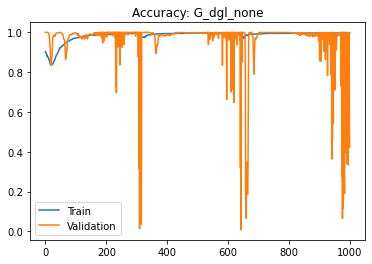

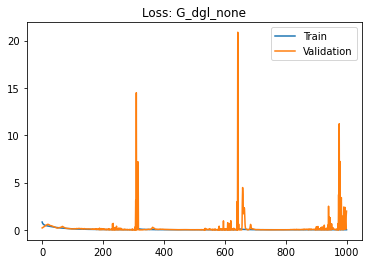

G_dgl_none 641 0.0371 0.9976 0.9977 0.0046 0.9995 0.9993


0    168
1    102
dtype: int64

,Gene,prediction,probability
581,aldoa,1,1.000000
643,lonp2,1,1.000000
658,pipox,1,0.992327
1276,med1,1,0.999990
1798,wipi2,1,1.000000
1932,eno2,1,1.000000
2286,chm,1,0.940583


G_dgl_cca


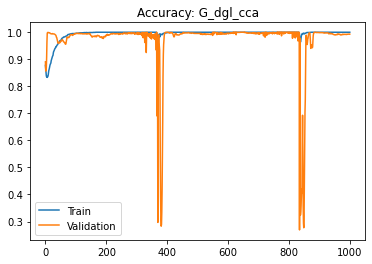

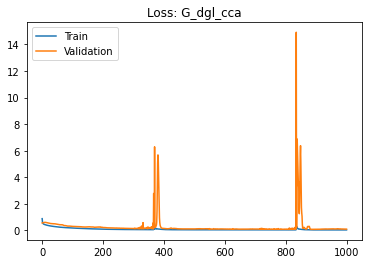

G_dgl_cca 885 0.0465 1.0000 1.0000 0.0873 1.0000 1.0000


0    197
1     77
dtype: int64

,Gene,prediction,probability
658,pipox,1,0.985102
1798,wipi2,1,1.000000
2286,chm,1,0.999998


G_dgl_pls


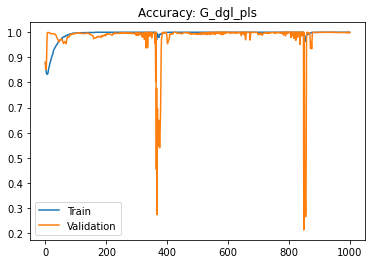

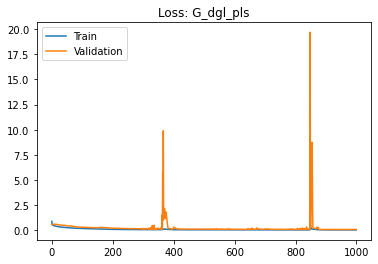

G_dgl_pls 994 0.0430 1.0000 1.0000 0.0828 1.0000 1.0000


0    198
1     77
dtype: int64

,Gene,prediction,probability
230,pycr1,1,0.999852
658,pipox,1,1.000000
1798,wipi2,1,1.000000
1917,madd,1,0.999997
2286,chm,1,1.000000


G_dgl_pearson


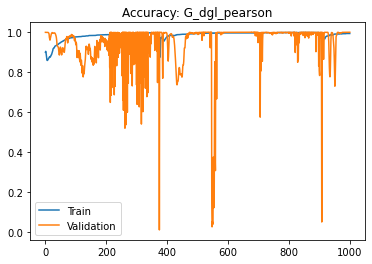

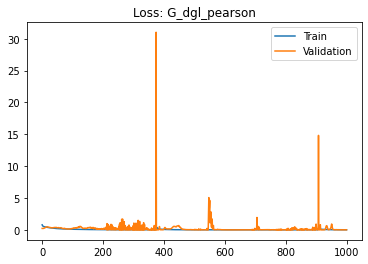

G_dgl_pearson 697 0.0233 0.9947 0.9951 0.0026 1.0000 1.0000


0    167
1    115
dtype: int64

,Gene,prediction,probability
230,pycr1,1,1.000000
658,pipox,1,0.999534
1611,itpr2,1,0.994436
1798,wipi2,1,1.000000
1917,madd,1,0.999497
2049,dennd4c,1,1.000000
2286,chm,1,1.000000


G_dgl_cca_neg


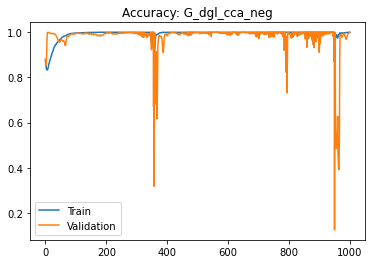

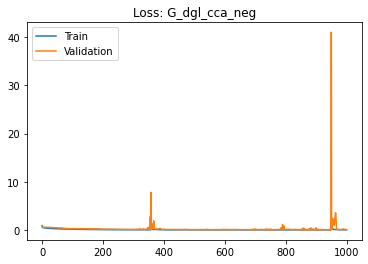

G_dgl_cca_neg 944 0.0429 1.0000 1.0000 0.0827 1.0000 1.0000


0    160
1    105
dtype: int64

,Gene,prediction,probability
230,pycr1,1,0.999080
658,pipox,1,1.000000
1798,wipi2,1,1.000000
1917,madd,1,0.989321
1932,eno2,1,0.962412
2286,chm,1,1.000000


G_dgl_pls_neg


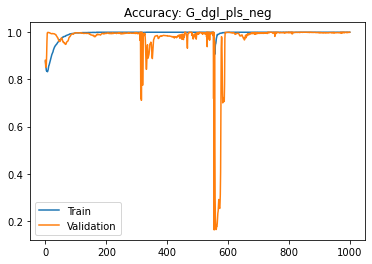

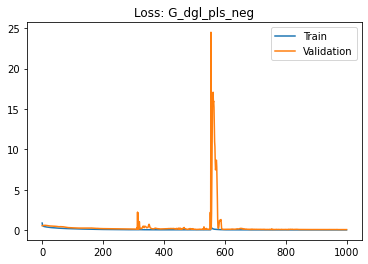

G_dgl_pls_neg 996 0.0429 1.0000 1.0000 0.0821 1.0000 1.0000


0    157
1    110
dtype: int64

,Gene,prediction,probability
230,pycr1,1,0.947280
658,pipox,1,0.999998
1798,wipi2,1,1.000000
1917,madd,1,0.925327
1932,eno2,1,0.997914
2286,chm,1,1.000000


G_dgl_pearson_neg


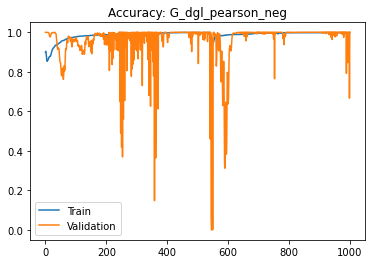

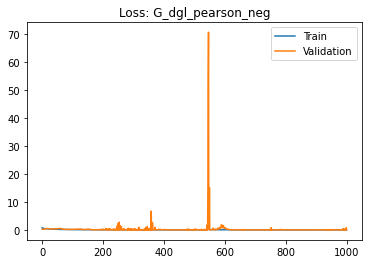

G_dgl_pearson_neg 775 0.0246 0.9947 0.9951 0.0013 1.0000 1.0000


0    153
1    122
dtype: int64

,Gene,prediction,probability
230,pycr1,1,1.0
581,aldoa,1,1.0
643,lonp2,1,1.0
658,pipox,1,1.0
1611,itpr2,1,1.0
1798,wipi2,1,1.0
1917,madd,1,1.0
1932,eno2,1,1.0
2049,dennd4c,1,1.0
2286,chm,1,1.0


G_dgl_gini


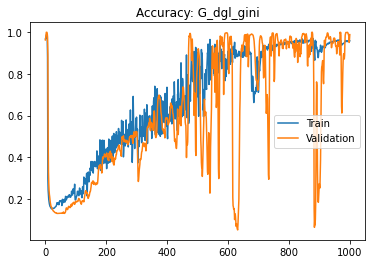

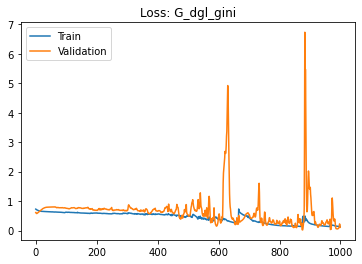

G_dgl_gini 875 0.2264 0.9556 0.9690 0.0199 0.9995 0.9993


0    227
1     64
dtype: int64

,Gene,prediction,probability
581,aldoa,1,1.0
643,lonp2,1,1.0
1276,med1,1,1.0
1932,eno2,1,1.0


G_dgl_shannon


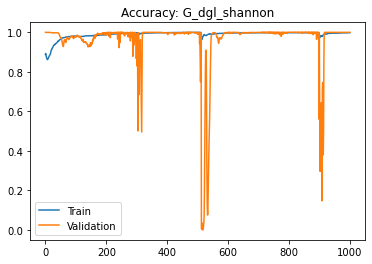

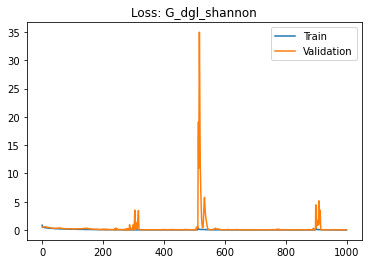

G_dgl_shannon 498 0.0263 0.9986 0.9986 0.0313 1.0000 1.0000


1    136
0    126
dtype: int64

,Gene,prediction,probability
230,pycr1,1,0.920539
658,pipox,1,0.999705
1798,wipi2,1,1.000000
1917,madd,1,1.000000
2286,chm,1,0.999172


G_dgl_renyi


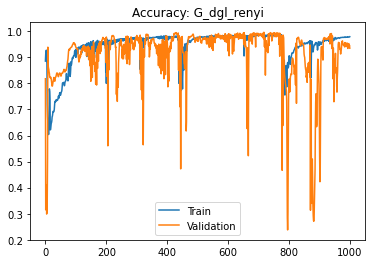

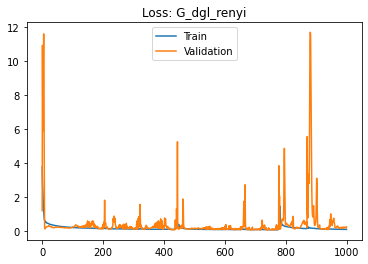

G_dgl_renyi 717 0.0947 0.9711 0.9785 0.0574 0.9965 0.9978


0    99
dtype: int64

,Gene,prediction,probability


G_dgl_tsallis


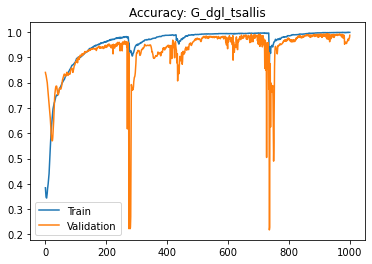

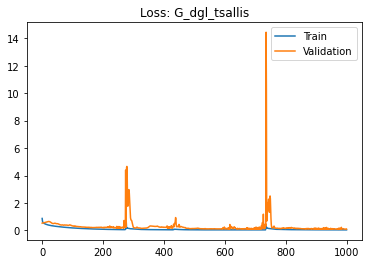

G_dgl_tsallis 973 0.0418 0.9981 0.9981 0.0781 0.9896 0.9943


0    136
1    107
dtype: int64

,Gene,prediction,probability
230,pycr1,1,0.997229
643,lonp2,1,0.957071
1276,med1,1,0.947867
1326,hk1,1,0.989542
1611,itpr2,1,0.999979
1798,wipi2,1,0.998297
1932,eno2,1,1.000000
2286,chm,1,0.998909


G_dgl_mutualInfo


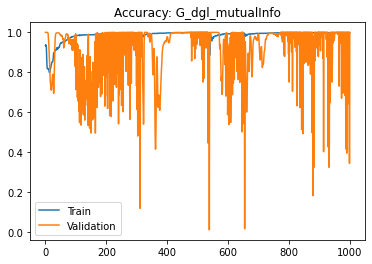

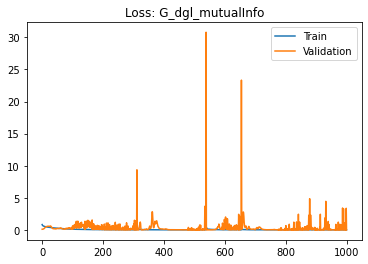

G_dgl_mutualInfo 990 0.0195 0.9990 0.9991 0.0022 1.0000 1.0000


0    153
1    114
dtype: int64

,Gene,prediction,probability
230,pycr1,1,1.000000
658,pipox,1,0.999811
1798,wipi2,1,1.000000
1917,madd,1,0.996345
1932,eno2,1,0.969585
2286,chm,1,0.999999


G_dgl_kl


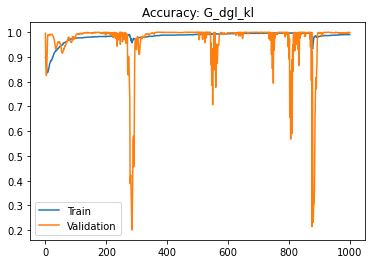

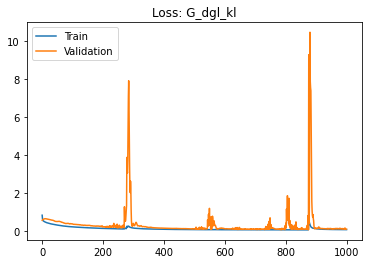

G_dgl_kl 874 0.0753 0.9961 0.9964 0.0619 0.9995 0.9993


0    216
1     62
dtype: int64

,Gene,prediction,probability
230,pycr1,1,0.997953
581,aldoa,1,1.000000
643,lonp2,1,1.000000
1932,eno2,1,1.000000


G_dgl_js


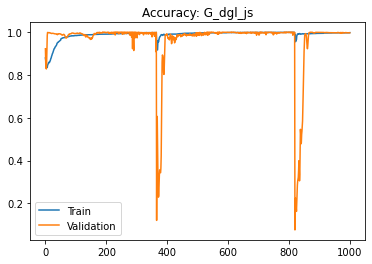

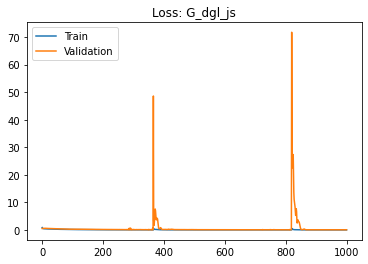

G_dgl_js 743 0.0490 0.9990 0.9991 0.0876 1.0000 1.0000


1    133
0    130
dtype: int64

,Gene,prediction,probability
230,pycr1,1,0.999999
643,lonp2,1,1.000000
658,pipox,1,0.999912
713,camsap3,1,1.000000
1326,hk1,1,0.945193
1611,itpr2,1,0.999845
1798,wipi2,1,1.000000
1917,madd,1,0.915478
1932,eno2,1,0.992268
2286,chm,1,1.000000


In [97]:

input_shape = all_data.iloc[:, 2:].shape[1]
hidden_size = 50
learning_rate = 0.0010

all_logits = []
for g_name,g in variable_map.items():
    torch.manual_seed(42)
    net = GCN(input_shape, hidden_size, 2, weight=torch.double)
    g = dgl.add_self_loop(g)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.01) #weight_Decay: l2 penalty
    f1 = F1Score(task="multiclass", num_classes=2, average="weighted")
    n_epochs = 1000
    probability_train=[]
    probability_val=[]
    probability_test=[]
    prediction_train=[]
    prediction_val=[]
    prediction_test=[]
    train_acc=[]
    train_loss=[]
    train_f1=[]
    val_loss=[]
    val_acc=[]
    val_f1=[]
    score=[]
    for epoch in range(n_epochs):
        net.train()
        g_train=g.subgraph(train_indices)
        g_train.ndata['label']=node_labels[train_indices]
        if 'weight' in g_train.edata.keys():
            edge_weight = g_train.edata['weight'].double().float()
        else:
            edge_weight = None

        logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
        # save the logits for visualization later
        logp_train = F.log_softmax(logits_train, 1)
        probs_train=torch.exp(logp_train)
        prob_train,predicted_train=torch.max(probs_train, 1)
        probability_train.append(prob_train)
        prediction_train.append(predicted_train)
        loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([0.0004,0.037])) 
        train_loss.append(loss)
        correct = (predicted_train == node_labels[train_indices]).sum().item()
        accuracy = correct / len(train_indices)
        train_acc.append(accuracy)
        f1_score=f1(predicted_train,node_labels[train_indices])
        train_f1.append(f1_score)

        net.eval()
        g_val=g.subgraph(val_indices)
        if 'weight' in g_val.edata.keys():
            edge_weight = g_val.edata['weight'].double().float()
        else:
            edge_weight = None
        logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
        logp_val = F.log_softmax(logits_val, 1)
        probs_val=torch.exp(logp_val)
        prob_val,predicted_val=torch.max(probs_val, 1)
        probability_val.append(prob_val)
        prediction_val.append(predicted_val)
        loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
        val_loss.append(loss_val)
        val_correct = (predicted_val == node_labels[val_indices]).sum().item()
        val_accuracy = val_correct / len(val_indices)
        val_acc.append(val_accuracy)
        f1_score_val=f1(predicted_val,node_labels[val_indices])
        val_f1.append(f1_score_val)

        # test part
        g_test=g.subgraph(test_indices)
        if 'weight' in g_test.edata.keys():
            edge_weight = g_test.edata['weight'].double().float()
        else:
            edge_weight = None
        logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
        logp_test = F.log_softmax(logits_test, 1)
        probs_test=torch.exp(logp_test)
        prob_test,predicted_test=torch.max(probs_test, 1)
        probability_test.append(prob_test)
        prediction_test.append(predicted_test)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    
    print(g_name)
    plt.plot(range(0, n_epochs), [acc for acc in train_acc], label="Train")
    plt.plot(range(0, n_epochs), [acc for acc in val_acc], label="Validation")
    plt.legend()
    plt.title(f"Accuracy: {g_name}")
    plt.show()

    plt.plot(range(0, n_epochs), [loss.item() for loss in train_loss], label="Train")
    plt.plot(range(0, n_epochs), [loss.item() for loss in val_loss], label="Validation")
    plt.legend()
    plt.title(f"Loss: {g_name}")
    plt.show()

    min_unl_loss = np.argmin([i.item() for i in val_loss])

    print(g_name,min_unl_loss,"%.4f" %train_loss[min_unl_loss].item(),"%.4f" %train_acc[min_unl_loss],
                       "%.4f" %train_f1[min_unl_loss].item(),"%.4f" %val_loss[min_unl_loss].item(),
                       "%.4f" %val_acc[min_unl_loss],"%.4f" %val_f1[min_unl_loss].item())
        
    pred=[label for prob, label in zip(probability_test[min_unl_loss], prediction_test[min_unl_loss]) if prob > 0.9]
    predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
    predicted_df=pd.merge(all_data, predicted_labels, left_index=True, right_index=True,
                               how="inner")[['Gene','prediction','probability']]
    fmr1=predicted_df[predicted_df['Gene']=='fmr1'][['prediction','probability']].values[0]
    pred_counts = pd.DataFrame(pred).value_counts()

    if 1 in pred_counts.index:
        patho_genes = pred_counts[1]
    else:
        patho_genes = 0
    list2=predicted_df[predicted_df['Gene'].isin(candidate_genes)]
    cand_len=len(list2[(list2['prediction']==1)&(list2['probability']>0.9)])
    all_logits.append([g_name,min_unl_loss,"%.4f" %train_loss[min_unl_loss].item(),"%.4f" %train_acc[min_unl_loss],
                       "%.4f" %train_f1[min_unl_loss].item(),"%.4f" %val_loss[min_unl_loss].item(),
                       "%.4f" %val_acc[min_unl_loss],"%.4f" %val_f1[min_unl_loss].item(),patho_genes,cand_len,['pred:' + str(fmr1[0]), 'prob:' + str(fmr1[1])]])
    
    display(pd.DataFrame(pred).value_counts())
    display(list2[(list2['prediction']==1)&(list2['probability']>0.9)])
    

In [98]:
result_df=pd.DataFrame(all_logits,
                       columns=['weight method','epoch','train loss','train acc','train f1','val loss','val acc','val f1','prediction','candidate genes','fmr1'])

In [99]:
result_df.sort_values('candidate genes',ascending=False)

,weight method,epoch,train loss,train acc,train f1,val loss,val acc,val f1,prediction,candidate genes,fmr1
6,G_dgl_pearson_neg,775,0.0246,0.9947,0.9951,0.0013,1.0000,1.0000,122,10,"[pred:0.0, prob:0.9250935912132263]"
13,G_dgl_js,743,0.0490,0.9990,0.9991,0.0876,1.0000,1.0000,133,10,"[pred:1.0, prob:1.0]"
10,G_dgl_tsallis,973,0.0418,0.9981,0.9981,0.0781,0.9896,0.9943,107,8,"[pred:1.0, prob:1.0]"
0,G_dgl_none,641,0.0371,0.9976,0.9977,0.0046,0.9995,0.9993,102,7,"[pred:0.0, prob:0.9395442605018616]"
3,G_dgl_pearson,697,0.0233,0.9947,0.9951,0.0026,1.0000,1.0000,115,7,"[pred:1.0, prob:1.0]"
4,G_dgl_cca_neg,944,0.0429,1.0000,1.0000,0.0827,1.0000,1.0000,105,6,"[pred:1.0, prob:0.9999765157699585]"
5,G_dgl_pls_neg,996,0.0429,1.0000,1.0000,0.0821,1.0000,1.0000,110,6,"[pred:1.0, prob:1.0]"
11,G_dgl_mutualInfo,990,0.0195,0.9990,0.9991,0.0022,1.0000,1.0000,114,6,"[pred:1.0, prob:1.0]"
2,G_dgl_pls,994,0.0430,1.0000,1.0000,0.0828,1.0000,1.0000,77,5,"[pred:0.0, prob:0.9210191965103149]"
8,G_dgl_shannon,498,0.0263,0.9986,0.9986,0.0313,1.0000,1.0000,136,5,"[pred:1.0, prob:1.0]"


#### Final Network with best edge weight and hyper-parameters

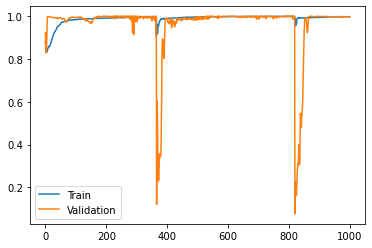

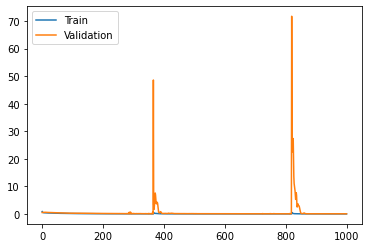

743 0.0490 0.9990 0.9991 0.0876 1.0000 1.0000


1    133
0    130
dtype: int64

In [100]:

input_shape = all_data.iloc[:, 2:].shape[1]
hidden_size = 50
learning_rate = 0.0010
torch.manual_seed(42)

g=G_dgl_js
net = GCN(input_shape, hidden_size, 2, weight=torch.double)
g = dgl.add_self_loop(g)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.01) #weight_Decay: l2 penalty
f1 = F1Score(task="multiclass", num_classes=2, average="weighted")
n_epochs = 1000
probability_train=[]
probability_val=[]
probability_test=[]
prediction_train=[]
prediction_val=[]
prediction_test=[]
train_acc=[]
train_loss=[]
train_f1=[]
val_loss=[]
val_acc=[]
val_f1=[]

for epoch in range(n_epochs):
    net.train()
    g_train=g.subgraph(train_indices)
    g_train.ndata['label']=node_labels[train_indices]
    if 'weight' in g_train.edata.keys():
        edge_weight = g_train.edata['weight'].double().float()
    else:
        edge_weight = None

    logits_train = net(g_train, g_train.ndata['feat'].double().float(),edge_weight=edge_weight)
    # save the logits for visualization later
    logp_train = F.log_softmax(logits_train, 1)
    probs_train=torch.exp(logp_train)
    prob_train,predicted_train=torch.max(probs_train, 1)
    probability_train.append(prob_train)
    prediction_train.append(predicted_train)
    loss=F.nll_loss(logp_train, node_labels[train_indices].type(torch.LongTensor),weight=torch.tensor([0.0004,0.037])) 
    train_loss.append(loss)
    correct = (predicted_train == node_labels[train_indices]).sum().item()
    accuracy = correct / len(train_indices)
    train_acc.append(accuracy)
    f1_score=f1(predicted_train,node_labels[train_indices])
    train_f1.append(f1_score)

    net.eval()
    g_val=g.subgraph(val_indices)
    if 'weight' in g_val.edata.keys():
        edge_weight = g_val.edata['weight'].double().float()
    else:
        edge_weight = None
    logits_val = net(g_val, g_val.ndata['feat'].double().float(),edge_weight=edge_weight)
    logp_val = F.log_softmax(logits_val, 1)
    probs_val=torch.exp(logp_val)
    prob_val,predicted_val=torch.max(probs_val, 1)
    probability_val.append(prob_val)
    prediction_val.append(predicted_val)
    loss_val=F.nll_loss(logp_val, node_labels[val_indices].type(torch.LongTensor))
    val_loss.append(loss_val)
    val_correct = (predicted_val == node_labels[val_indices]).sum().item()
    val_accuracy = val_correct / len(val_indices)
    val_acc.append(val_accuracy)
    f1_score_val=f1(predicted_val,node_labels[val_indices])
    val_f1.append(f1_score_val)

    # test part
    g_test=g.subgraph(test_indices)
    if 'weight' in g_test.edata.keys():
        edge_weight = g_test.edata['weight'].double().float()
    else:
        edge_weight = None
    logits_test = net(g_test, g_test.ndata['feat'].double().float(),edge_weight=edge_weight)
    logp_test = F.log_softmax(logits_test, 1)
    probs_test=torch.exp(logp_test)
    prob_test,predicted_test=torch.max(probs_test, 1)
    probability_test.append(prob_test)
    prediction_test.append(predicted_test)
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

plt.plot(range(0, n_epochs), [acc for acc in train_acc], label="Train")
plt.plot(range(0, n_epochs), [acc for acc in val_acc], label="Validation")
plt.legend()
plt.show()

plt.plot(range(0, n_epochs), [loss.item() for loss in train_loss], label="Train")
plt.plot(range(0, n_epochs), [loss.item() for loss in val_loss], label="Validation")
plt.legend()
plt.show()

min_unl_loss = np.argmin([i.item() for i in val_loss])

print(min_unl_loss,"%.4f" %train_loss[min_unl_loss].item(),"%.4f" %train_acc[min_unl_loss],
                   "%.4f" %train_f1[min_unl_loss].item(),"%.4f" %val_loss[min_unl_loss].item(),
                   "%.4f" %val_acc[min_unl_loss],"%.4f" %val_f1[min_unl_loss].item())


pred=[label for prob, label in zip(probability_test[min_unl_loss], prediction_test[min_unl_loss]) if prob > 0.9]
predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
predicted_df=pd.merge(all_data, predicted_labels, left_index=True, right_index=True,
                           how="inner")[['Gene','prediction','probability']]
pred_counts = pd.DataFrame(pred).value_counts()

if 1 in pred_counts.index:
    patho_genes = pred_counts[1]
else:
    patho_genes = 0

display(pd.DataFrame(pred).value_counts())

In [101]:
pd.DataFrame(prediction_test[min_unl_loss]).value_counts()

0    161
1    148
dtype: int64

In [102]:
pd.DataFrame(prediction_train[min_unl_loss]).value_counts()

0    2045
1      28
dtype: int64

In [103]:
pd.DataFrame(prediction_val[min_unl_loss]).value_counts()

0    2022
1       1
dtype: int64

In [104]:
predicted_labels_train=pd.DataFrame({'prediction':[i.item() for i in prediction_train[min_unl_loss]],'probability':[i.item() for i in probability_train[min_unl_loss]]}).set_index(train_indices)
predicted_df_train=pd.merge(all_data, predicted_labels_train, left_index=True, right_index=True,
                               how="inner")[['Gene','prediction','probability','Pathogenic']]
len(predicted_df_train)

2073

In [105]:
predicted_labels_val=pd.DataFrame({'prediction':[i.item() for i in prediction_val[min_unl_loss]],'probability':[i.item() for i in probability_val[min_unl_loss]]}).set_index(val_indices)
predicted_df_val=pd.merge(all_data, predicted_labels_val, left_index=True, right_index=True,
                               how="inner")[['Gene','prediction','probability','Pathogenic']]


In [106]:
predicted_labels=pd.DataFrame({'prediction':[i.item() for i in prediction_test[min_unl_loss]],'probability':[i.item() for i in probability_test[min_unl_loss]]}).set_index(test_indices)
predicted_df=pd.merge(all_data, predicted_labels, left_index=True, right_index=True,
                               how="inner")[['Gene','prediction','probability']]


In [107]:
predicted_df[predicted_df['Gene']=='fmr1']

,Gene,prediction,probability
1411,fmr1,1,1.0


In [108]:
predicted_df[(predicted_df['probability']>0.9)]['prediction'].value_counts()

1    133
0    130
Name: prediction, dtype: int64

In [109]:
predicted_df['probability']=predicted_df['probability'].apply(lambda x: round(x, 2))
predicted_df

,Gene,prediction,probability
0,ganab,0,0.99
1,fus,1,1.00
13,nt5c3b,0,1.00
19,abcb6,1,1.00
20,tia1,0,0.66
...,...,...,...
2365,gcat,0,0.89
2368,oat,0,1.00
2375,acss2,0,0.52
2376,cgn,1,0.80


In [110]:
preds_df=predicted_df[(predicted_df['probability']>0.9)&(predicted_df['prediction']==1)]
preds_df['probability'].value_counts(),len(preds_df)

(1.00    120
 0.99      5
 0.97      2
 0.95      2
 0.91      1
 0.98      1
 0.92      1
 0.94      1
 Name: probability, dtype: int64,
 133)

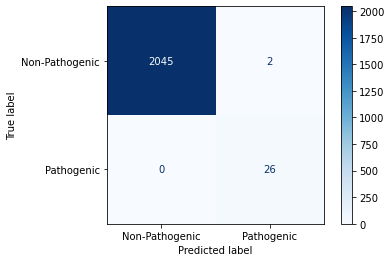

In [111]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
cm=confusion_matrix(node_labels[train_indices],prediction_train[min_unl_loss])
disp = ConfusionMatrixDisplay(cm,display_labels=['Non-Pathogenic', 'Pathogenic']) #display_labels=['Class 0', 'Class 1']
disp.plot(cmap=plt.cm.Blues)

In [112]:
print(classification_report(node_labels[train_indices],prediction_train[min_unl_loss]))  #per class accuracy = recall

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2047
           1       0.93      1.00      0.96        26

    accuracy                           1.00      2073
   macro avg       0.96      1.00      0.98      2073
weighted avg       1.00      1.00      1.00      2073



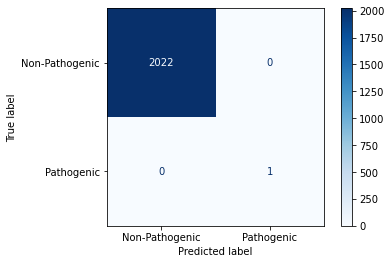

In [113]:
cm=confusion_matrix(node_labels[val_indices],prediction_val[min_unl_loss])
disp = ConfusionMatrixDisplay(cm,display_labels=['Non-Pathogenic', 'Pathogenic']) #display_labels=['Class 0', 'Class 1']
disp.plot(cmap=plt.cm.Blues)


In [114]:
print(classification_report(node_labels[val_indices],prediction_val[min_unl_loss]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2022
           1       1.00      1.00      1.00         1

    accuracy                           1.00      2023
   macro avg       1.00      1.00      1.00      2023
weighted avg       1.00      1.00      1.00      2023



### Visualize network

In [115]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [116]:
predicted_genes_all=pd.concat([predicted_df_train,predicted_df],axis=0).sort_index()
predicted_genes_all

,Gene,prediction,probability,Pathogenic
0,ganab,0,0.990000,NaN
1,fus,1,1.000000,NaN
2,kpna3,0,0.924956,0.0
3,napg,0,0.912077,0.0
4,trappc11,0,0.889713,0.0
...,...,...,...,...
2377,tecr,0,0.987384,0.0
2378,pomk,0,0.946402,0.0
2379,adipor1,0,0.986061,0.0
2380,tubgcp3,0,0.978601,0.0


In [117]:
predicted_genes_all[predicted_genes_all['Pathogenic']==1]

,Gene,prediction,probability,Pathogenic
247,apc,1,0.979628,1.0
273,ocrl,1,0.942183,1.0
304,grip1,1,0.991331,1.0
476,cc2d1a,1,0.998923,1.0
869,auts2,1,0.999906,1.0
897,dvl3,1,0.951774,1.0
961,kdm4b,1,0.998650,1.0
1079,ank3,1,0.998711,1.0
1202,ehmt1,1,0.999387,1.0
1317,dmxl2,1,0.994491,1.0


In [118]:
relabel_nodes

{'ganab': 0,
 'fus': 1,
 'kpna3': 2,
 'napg': 3,
 'trappc11': 4,
 'rpl32': 5,
 'szt2': 6,
 'sf3b3': 7,
 'ythdf2': 8,
 'snrpe': 9,
 'aaas': 10,
 'rpl22': 11,
 'becn1': 12,
 'nt5c3b': 13,
 'rock2': 14,
 'anapc7': 15,
 'ak3': 16,
 'rgs14': 17,
 'pfas': 18,
 'abcb6': 19,
 'tia1': 20,
 'ate1': 21,
 'srp14': 22,
 'rsph9': 23,
 'jph3': 24,
 'cdc40': 25,
 'edc4': 26,
 'stx17': 27,
 'acat2': 28,
 'elof1': 29,
 'gpsm1': 30,
 'uba5': 31,
 'atg13': 32,
 'als2': 33,
 'fnbp1l': 34,
 'synj2bp': 35,
 'ewsr1': 36,
 'golga4': 37,
 'vps39': 38,
 'cab39': 39,
 'appl2': 40,
 'ssb': 41,
 'anapc2': 42,
 'etfa': 43,
 's100a6': 44,
 'trmt6': 45,
 'ube2g2': 46,
 'map2k2': 47,
 'tpd52': 48,
 'arhgef10l': 49,
 'dhx9': 50,
 'atic': 51,
 'angel2': 52,
 'cdk11b': 53,
 'ddx5': 54,
 'dnajc10': 55,
 'prkar2a': 56,
 'ap3b2': 57,
 'pdk3': 58,
 'tomm34': 59,
 'tagln2': 60,
 'ppme1': 61,
 'ndufaf2': 62,
 'atg12': 63,
 'slc9a3r1': 64,
 'pak6': 65,
 'st13': 66,
 'snx8': 67,
 'ctsd': 68,
 'pxn': 69,
 'get4': 70,
 'dpcd': 71,


In [119]:
list1=predicted_df_train[predicted_df_train['Gene'].isin(candidate_genes)]['Gene'].values.tolist()
list2=predicted_df[predicted_df['Gene'].isin(candidate_genes)]['Gene'].values.tolist()
list1.extend(list2)
cand_genes=[relabel_nodes[key] for key in list1]
len(cand_genes)

27

In [120]:
#for candidate gene
Graph_cand=nx.subgraph(G_js, cand_genes)

In [121]:
required = [relabel_nodes[key] for key in list(nx.ego_graph(G, 'fmr1', radius=2).nodes()) if key in relabel_nodes]

For_G1=nx.subgraph(G_js, required) #for all genes pass respective gene directly 

In [122]:
# Identify the connected components
components = list(nx.connected_components(G_js))

# Find the largest component (main set of network groups)
largest_component = max(components, key=len)

# Create a subgraph with only the nodes in the largest component
filtered_graph = G_js.subgraph(largest_component)

In [123]:
len(list(filtered_graph.nodes))

2308

1


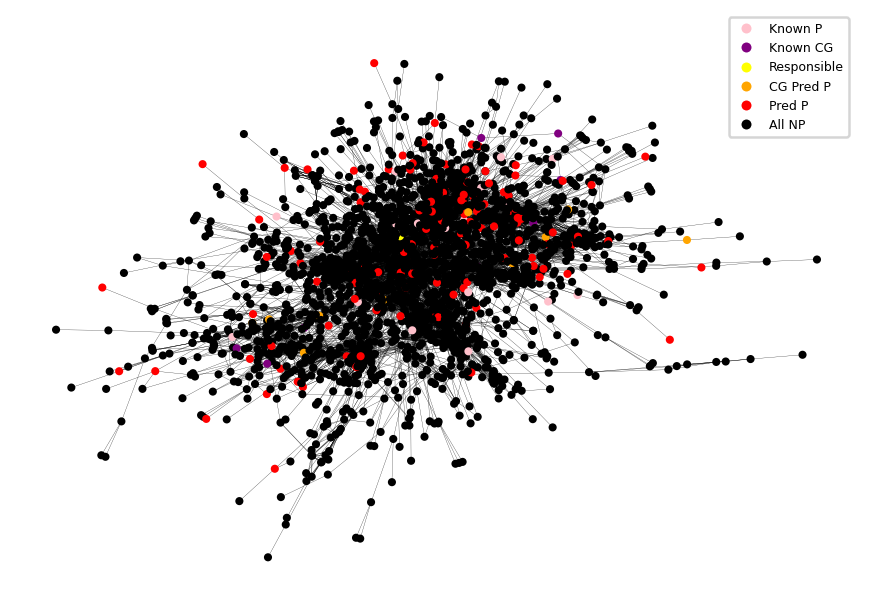

In [124]:
# To get graph with respect to candidate genes or responsible gene, replace 'filtered_graph' with Graph_cand or For_G1
def draw(frame):
    colors = []
    for v in filtered_graph.nodes:
        if predicted_genes_all['Gene'][v] in candidate_genes:
            if predicted_genes_all['Pathogenic'][v]==1:
                colors.append("#800080")
            elif predicted_genes_all['prediction'][v]==1 and predicted_genes_all['probability'][v]>0.9:
                colors.append("#FFA500")
            else:
                colors.append("#000000")
        else:
            if predicted_genes_all['Pathogenic'][v]==1:
                colors.append("#FFC0CB")
            elif predicted_genes_all['Pathogenic'][v]==0:
                colors.append("#000000")
            elif predicted_genes_all['prediction'][v]==1 and predicted_genes_all['Gene'][v]=='fmr1':
                colors.append("#FFFF00")
            elif predicted_genes_all['prediction'][v]==1 and predicted_genes_all['probability'][v]>0.9:
                colors.append("#FF0000")
            else:
                colors.append("#000000")
    ax.cla()
    ax.axis('off')
    p=nx.spring_layout(filtered_graph.to_undirected())
    node_labels = {k: v for v, k in relabel_nodes.items() if k in required } 
    nx.draw_networkx(filtered_graph.to_undirected(), p, node_color=colors,
            with_labels=False, node_size=5, ax=ax, width=0.1)
   # nx.draw_networkx_labels(G_draw.to_undirected(), p, labels=node_labels, font_size=6, font_color='black')
    legend_labels = {
        'Known P': "#FFC0CB",
        'Known CG':"#800080",
        'Responsible':"#FFFF00",
        'CG Pred P':"#FFA500",
        'Pred P':"#FF0000",
        'All NP':"#000000"
    }
    
    # Display the legend
    for label, color in legend_labels.items():
        ax.plot([], [], marker='o', color='w', markerfacecolor=color, label=label, markersize=5)
    ax.legend(loc='upper right',fontsize=5,bbox_to_anchor=(1, 1.05))
    print(frame)  # displaying frame number might be useful to keep track of time while generating animation
fig = plt.figure(dpi=180)
fig.clf()
ax = fig.subplots()
draw(1)

#### Animation ; takes lot of time

In [125]:
# import matplotlib
# matplotlib.rcParams['animation.embed_limit'] = 2**128
# matplotlib.rc('animation', html='jshtml')
# ani = animation.FuncAnimation(fig, draw, frames=len(filtered_graph.nodes), interval=500)
# ani

In [126]:
# ani.save('Gene_network_Autism.gif', writer='pillow')

In [127]:
print("Done")

Done
